# 타이타닉 데이터를 활용한 이진 생존 분류
- Downloads: https://www.kaggle.com/c/titanic

### 1. Data Description
- total: 1309명
- train.csv: 891 x 12
- test.csv: 418 x 11

- Survival: 0=No, 1=Yes
- pclass: 1=1st, 2=2nd, 3=3rd(숫자가 낮을수록 높은 등급)
- SibSp = Siblings-Spouses
- Parch = Parants-Children

### 2. Import Module

In [1]:
import pandas as pd  # 데이터 전처리, 탐색, 분석
import numpy as np  # 수치해석
import matplotlib.pyplot as plt  # 그래프

### 3. Data Load

In [2]:
df_train = pd.read_csv('./dataset/train.csv')  # .현재 .. /들어가기(폴더 더블클릭)
df_test = pd.read_csv('./dataset/test.csv')  # ..뒤로가기(폴더 빠져나온다)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(type(df_train))
print(type(df_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### 4. Data Exploration

In [5]:
# Data Size 확인
print(df_train.shape) #앞이 행 뒤가 열
print(df_test.shape)

(891, 12)
(418, 11)


In [6]:
# Data Tyoe 및 Null 확인 #null은 결측치
# Cabin, Age, Embarked : 3가지 feature Null 존재(결측치)
# -> Null(결측치) 어떻게 처리할 것인지 고민
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# Column별 결측치(Missing Value) 합계
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
# Feature 목록 추출 및 Type
print(df_train.columns)
print(df_train.columns.values) # list

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [14]:
# 문자열(Object) 안나옴, only 수치형 타입
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
# Ticket은 중복되는 티켓이 여러 사람에게 동시 발행 => 가족 단위 추론
# => 티켓과 생존간의 상관관계(아마 의미 없을 듯)
df_train.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Harris, Mr. George",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [18]:
# column category 확인
df_train["Survived"].unique()

array([0, 1], dtype=int64)

In [19]:
df_train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

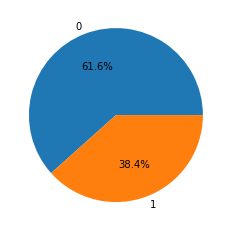

In [24]:
ratio = df_train["Survived"].value_counts()
labels = df_train["Survived"].unique()
plt.pie(ratio, labels=labels, autopct="%.1f%%")
plt.show()

In [26]:
df_train['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [27]:
df_train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

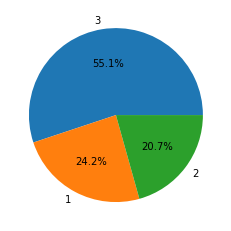

In [28]:
ratio = df_train["Pclass"].value_counts()
labels = df_train["Pclass"].unique()
plt.pie(ratio, labels=labels, autopct="%.1f%%")
plt.show()

### 5.데이터 추출

In [30]:
# Column 추출(1개)
df_train['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [35]:
# Column 추출 여러개
df_train[["Age","Pclass","Name"]] #다수를 추출하려면 대괄호 한번더

,Age,Pclass,Name
0,22.0,3,"Braund, Mr. Owen Harris"
1,38.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,26.0,3,"Heikkinen, Miss. Laina"
3,35.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,35.0,3,"Allen, Mr. William Henry"
...,...,...,...
886,27.0,2,"Montvila, Rev. Juozas"
887,19.0,1,"Graham, Miss. Margaret Edith"
888,NaN,3,"Johnston, Miss. Catherine Helen ""Carrie"""
889,26.0,1,"Behr, Mr. Karl Howell"


In [38]:
# iloc를 사용한 Row 추출 => 기존에 자동으로 생성 된 index
df_train.iloc[3]

# loc를 사용한 Row 추출 => 우리가 생성한 Label
# df_train.loc[label]

PassengerId                                               4
Survived                                                  1
Pclass                                                    1
Name           Futrelle, Mrs. Jacques Heath (Lily May Peel)
Sex                                                  female
Age                                                      35
SibSp                                                     1
Parch                                                     0
Ticket                                               113803
Fare                                                   53.1
Cabin                                                  C123
Embarked                                                  S
Name: 3, dtype: object

### 6. 데이터 분석

In [39]:
# Pclass(티켓 등급). 티켓 등급별 생존율 분석
df_train[["Pclass", "Survived"]].groupby(["Pclass"]).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [46]:
df_train[["Sex","Survived"]].groupby(["Sex"]).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [45]:
# 상관분석
# * 1 ~ -1
# * 1에 가까울수록 양의 상관관계(니도 오르면 나도 오름)
# * -1에 가까울수록 음의 상관관계(니가 오르면 나는 내려감)
# * 0은 아무 관계도 없음
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


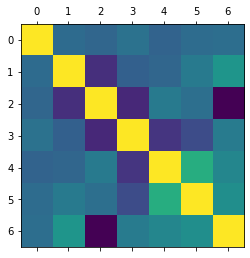

In [47]:
plt.matshow(df_train.corr())